# Explaining ProtoPNet Models

ProtoPNet is a model designed to automatically learn parts of an input in order to better explain what the neural network is focusing on. Once we have a model that learns parts of our input, it is important to determine how these parts contribute to our network's predictions. We can do this using a number of different methods. Two commonly used methods today are Shap and Lime, each of which is useful at explaining neural network models.

## Initial Setup

In [8]:
import numpy as np
import torch
from torch.utils.data import DataLoader

from deepards.dataset import ARDSRawDataset
from deepards.ppnet_push import viz_single_prototype


model_path = "saved_models/protopnet_final-epoch6-fold0.pth"
n_prototypes = 8
dataset_path = "/fastdata/deepards/unpadded_centered_with_bm-nb20-kfold.pkl"

x_train = ARDSRawDataset.from_pickle(dataset_path, False, 1.0, None, -1, None)
x_train.set_kfold_indexes_for_fold(0)
x_test = ARDSRawDataset.make_test_dataset_if_kfold(x_train)
train_loader = DataLoader(x_train, batch_size=1, shuffle=False)
test_loader = DataLoader(x_test, batch_size=1, shuffle=False)
model = torch.load(model_path).cuda().eval()

/home/greg/anaconda3/envs/deepardsdev3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/greg/anaconda3/envs/deepardsdev3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'deepards.models.protopnet.PPNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/greg/anaconda3/envs/deepardsdev3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.containe

## Translate Raw Sequence Data To MLP Features

In [54]:
# For shap to work you're going to need to translate the entire dataset from raw data into final 
# prototype distances you can do this with the model.seq_forward function. Then after processing,
# roll everything up into its own tensor and you can throw that into sklearn model.

def translate_torch_dataset_to_numpy(torch_model, torch_loader):
    all_outputs = []
    all_dists = []
    all_targets = []

    with torch.no_grad():
        for _, seq, __, target in torch_loader:
            inputs = seq.float().cuda()
            outputs, min_distances = torch_model.seq_forward(inputs[0])
            all_outputs.append(outputs.view(-1).unsqueeze(0).cpu().numpy())
            all_dists.append(min_distances.unsqueeze(0).cpu().numpy())
            all_targets.append(target.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_dists = np.concatenate(all_dists, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_outputs, all_dists, all_targets

In [10]:
all_outputs, all_dists, all_targets = translate_torch_dataset_to_numpy(model, train_loader)
all_test_outputs, all_test_dists, all_test_targets = translate_torch_dataset_to_numpy(model, test_loader)

## Translate Last Layer of PyTorch Model to Scikit-Learn

We need to perform translation because Shap does not natively support linear layers from PyTorch while using a `KernelExplainer`. So we convert all information from our PyTorch classification layer to scikit-learn

In [83]:
from sklearn.neural_network import MLPClassifier


def make_mlp_classifier(torch_model, all_train_outputs, all_train_targets):
    # setup a 1 layer MLP with no activation function.
    mlp = MLPClassifier(hidden_layer_sizes=[], activation='identity')
    # Run fit to initialize all the variables sklearn keeps hidden. We set the weights below so
    # this step has no impact on final weights
    mlp.fit(all_train_outputs[0:2], all_train_targets[0:2])

    torch_weights = model.last_layer.weight.detach().cpu().numpy().T
    # set mlp weights to the ones found in torch
    mlp.coefs_ = [torch_weights]
    # turn off bias
    mlp.intercepts_ = [np.array([0, 0])]
    # turn off final activation layer. 
    mlp.out_activation_ = 'identity'
    return mlp


mlp = make_mlp_classifier(model, all_outputs, all_targets)
# You can sanity check you're doing it OK by checking outputs versus the pytorch model
print('Sanity Check to Make Sure MLP and Torch are the Same')
print(mlp.predict_proba([all_outputs[1]]))
with torch.no_grad():
    print(model.last_layer(torch.FloatTensor([all_outputs[1]]).cuda()).cpu().numpy())

Sanity Check to Make Sure MLP and Torch are the Same
[[87.71662 95.92362]]
[[87.71662 95.92362]]


## Perform Shap Analysis

In [81]:
import sys

import pandas as pd


def make_feature_datasets(all_train_outputs, all_test_outputs, n_prototypes):
    # ensure that you name all the features in the model appropriately
    features = []
    for i in range(all_train_outputs.shape[1]):
        proto_n = i % n_prototypes
        # step function here that maps 0-7 -> 0, 8-15 -> 1 ...
        breath_n = int((i + n_prototypes - (i % n_prototypes))/n_prototypes - 1)
        # if we want, we can use subscripting, however I've also found that it makes it more difficult to read
        features.append(u'prototype {},{}'.format(breath_n, proto_n))

    train = pd.DataFrame(all_train_outputs, columns=features)
    test = pd.DataFrame(all_test_outputs, columns=features)
    return train, test


X_train, X_test = make_feature_datasets(all_outputs, all_test_outputs, n_prototypes)

In [ ]:
from scipy.special import softmax
import shap
shap.initjs()

# with a full dataset the KernelExplainer is dying from a SegmentationFault. This is probably being
# caused by memory issues. So for now we need to restrict it to a manageable amount of data while also
# ensuring that our model converges.
if shap.__verion__ == '0.36.0':
    # here the segmentationfault doesn't happen so we can choose more items to use
    n_rand_items = 9000
else:
    # in this case we need to use python2 and an earlier version of shap that cant handle large amounts 
    # of background data samples.
    n_rand_items = 3000
idxs = np.random.choice(X_train.index, size=n_rand_items, replace=False)

explainer = shap.KernelExplainer(mlp.predict_proba, X_train.loc[idxs], link="identity")
shap_values = explainer.shap_values(X_test.iloc[0:10], nsamples=128, l1_reg="num_features(5)")
model_out = mlp.predict_proba(X_test.iloc[0:10]

### Proof Of Concept Shap Analysis: Using a Small Number of Reads

In [35]:
# plot the SHAP values for the 
shap.force_plot(explainer.expected_value[0], shap_values[0][0:10,:], X_test.iloc[0:10], link="identity")

## Focusing On A Single Patient

In [36]:
from scipy.special import softmax

ground_truth = x_test.get_ground_truth_df()
X_test.index = ground_truth.index
patients = ground_truth.patient.unique()
# select a patient that isn't too computationally intense and has mix of ARDS / non-ARDS predictions
selected_pt = '0033RPI0520150603'
print("Selected Patient {}".format(selected_pt))
pt_idxs = ground_truth[ground_truth.patient == selected_pt].index

# Determine how the model would classify the patient
with torch.no_grad():
    pt_output = model.last_layer(torch.FloatTensor(X_test.loc[pt_idxs.values].values).cuda()).cpu().numpy()
pt_probs = softmax(pt_output, axis=1)

Selected Patient 0033RPI0520150603


### Basic Descriptive Stats

Aggregate predictions: ARDS, Percent Reads Classified ARDS: 0.5, N Reads: 336


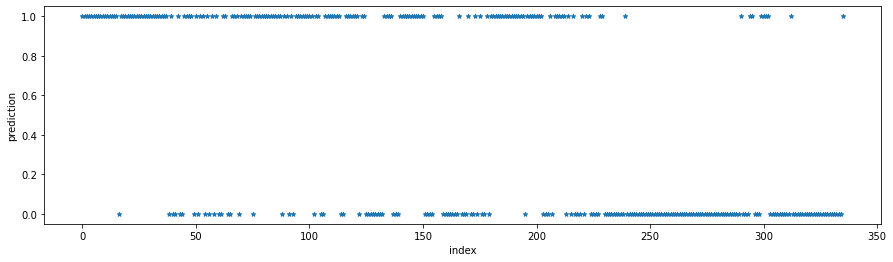

In [37]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 4]

pt_preds = pt_probs.argmax(axis=1)
prob = round(pt_preds.sum() / float(len(pt_preds)), 3)
if prob >= .5:
    prediction = 'ARDS'
else:
    prediction = 'Non-ARDS'
print("Aggregate predictions: {}, Percent Reads Classified ARDS: {}, N Reads: {}".format(prediction, prob, len(pt_preds)))
plt.scatter(np.arange(len(pt_preds)), pt_preds, s=20, marker='*')
plt.ylabel('prediction')
plt.xlabel('index')
plt.show()

### Visualizing Predictions With Shap

In [38]:
# Find shap values for all inputs. 
#
# We can set l1_reg to ensure convergence of the model. However if we set the regularization for number
# of features too high then we wont get any useful information and its possible our model will not converge.
# shap_values = explainer.shap_values(X_test.loc[pt_idxs], nsamples=72, l1_reg="num_features(3)")
shap_values = explainer.shap_values(X_test.loc[pt_idxs], nsamples=128, l1_reg="num_features(4)")

In [39]:
# Show force_plot for all predictions made for the patient.
#
# I think that Shap is just showing what the values are for the feature at this point, not showing 
# what the shap value is. The Shap value would be much lower in this circumstance. Also the values
# are being sorted in ascending order.
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[pt_idxs], link="identity")

In [40]:
# Show force_plot for only ARDS predictions.
ards_pred_mask = pt_probs.argmax(axis=1) == 1
ards_idxs = pt_idxs[ards_pred_mask]
shap.force_plot(explainer.expected_value[1], shap_values[1][ards_pred_mask,:], X_test.loc[ards_idxs], link="identity")

In [41]:
# Now look at non-ARDS predictions
pred_mask = pt_probs.argmax(axis=1) == 0
pred_idxs = pt_idxs[ards_pred_mask]
shap.force_plot(explainer.expected_value[1], shap_values[1][pred_mask,:], X_test.loc[pred_idxs], link="identity")

### Visualizing Single Prototypes

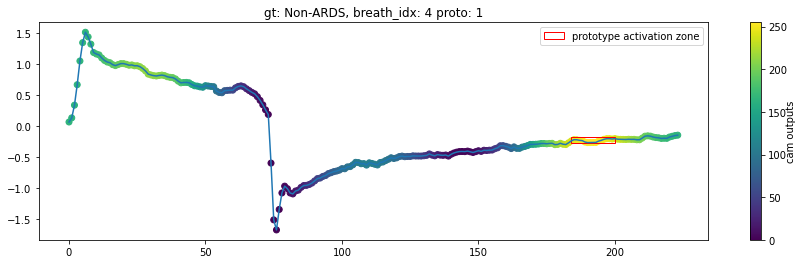

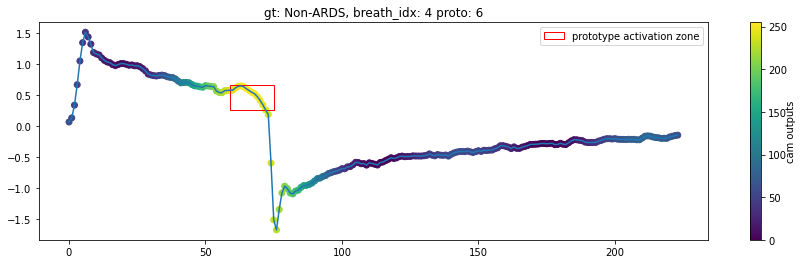

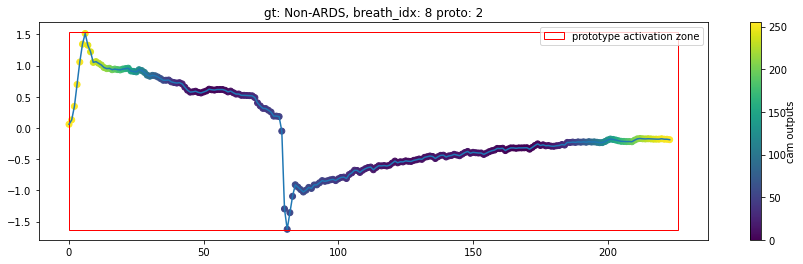

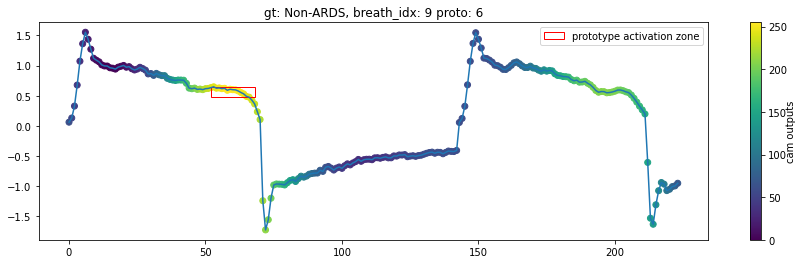

In [61]:
#from deepards.ppnet_push import viz_single_prototype
from deepards import ppnet_push


# XXX would be helpful to write everything up in a class.
def select_prototypes_by_magnitude(torch_dataset, mlp_features, ground_truth, pt, pred_mask, shap_values, shap_idx, shap_cutoff):
    mask = np.logical_and(pred_mask, np.any(shap_values[shap_idx] > shap_cutoff, axis=1))
    mask_idx = np.where(mask)[0]
    # just pick an item randomly
    rand_row_idx = np.random.choice(mask_idx)
    # Select the row and values
    gt_row = ground_truth[ground_truth.patient == pt].iloc[rand_row_idx]
    row_vals = mlp_features.loc[gt_row.name]
    sequence_data = torch_dataset[gt_row.name][1]
    # examine the prototypes in the random row
    feature_names = mlp_features.columns
    prototypes_of_interest = feature_names[shap_values[shap_idx][rand_row_idx] > 0]
    return prototypes_of_interest


def visualize_specific_prototypes(model, sequence_data, y, prototypes_of_interest):
    with torch.no_grad():
        protoL_input, distances = model.push_forward(torch.FloatTensor(sequence_data).cuda().unsqueeze(0))

    for idx, proto in enumerate(prototypes_of_interest):
        breath_n, proto_n = proto.split(' ')[1].split(',')
        breath_n, proto_n = int(breath_n), int(proto_n)
        ppnet_push.viz_single_prototype(model, sequence_data, y, protoL_input, distances, proto_n, breath_n)
        plt.show()
        
        
# For example purposes, pick an ARDS predicted read and a prototype with a large Shap value
prototypes_of_interest = select_prototypes_by_magnitude(x_test, X_test, ground_truth, selected_pt, ards_pred_mask, shap_values, 1, 2)
visualize_specific_prototypes(model, sequence_data, gt_row.y, prototypes_of_interest)

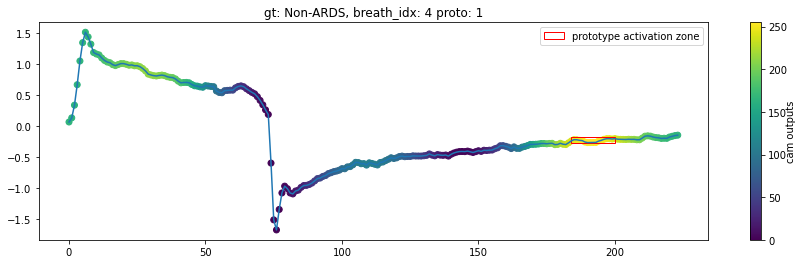

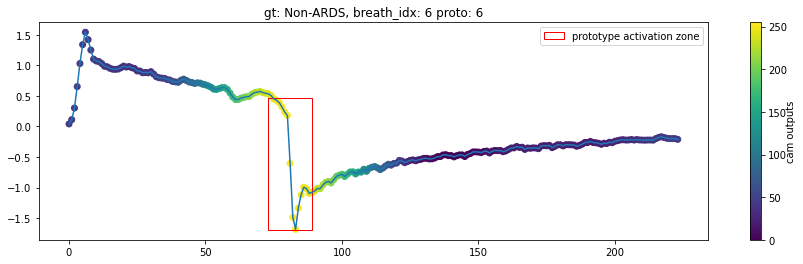

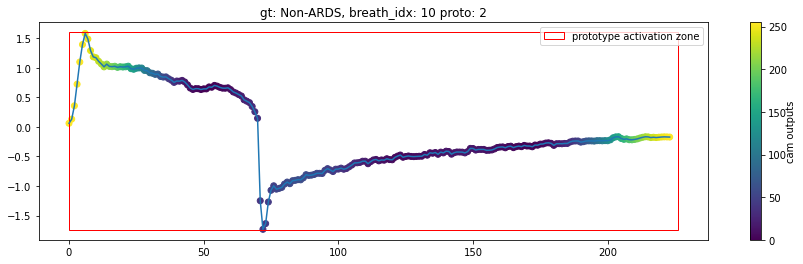

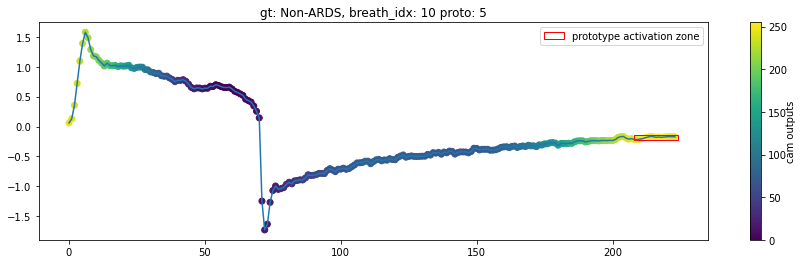

In [62]:
prototypes_of_interest = select_prototypes_by_magnitude(x_test, X_test, ground_truth, selected_pt, pred_mask, shap_values, 0, 2)
visualize_specific_prototypes(model, sequence_data, gt_row.y, prototypes_of_interest)

In [ ]:
# XXX need to figure out additional things to show. 

# XXX I can probably show the shap plot for each individual instance that I am also showing breath plots for.

## Visualizing Model With Incorrect Weights Set to Zero

In [77]:
model_path = "saved_models/protopnet-np6-zero-incorrect-protos-epoch10-fold0.pth"
n_prototypes = 12
model = torch.load(model_path).cuda().eval()

In [75]:
all_train_outputs, all_train_dists, all_train_targets = translate_torch_dataset_to_numpy(model, train_loader)
all_test_outputs, all_test_dists, all_test_targets = translate_torch_dataset_to_numpy(model, test_loader)

In [84]:
X_train, X_test = make_feature_datasets(all_train_outputs, all_test_outputs, n_prototypes)
mlp = make_mlp_classifier(model, all_outputs, all_targets)

# just choose 2000 to go faster
n_rand_items = 2000
idxs = np.random.choice(X_train.index, size=n_rand_items, replace=False)
explainer = shap.KernelExplainer(mlp.predict_proba, X_train.loc[idxs], link="identity")
shap_values = explainer.shap_values(X_test.iloc[0:10], nsamples=128, l1_reg="num_features(5)")
model_out = mlp.predict_proba(X_test.iloc[0:10])

Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
# 0033 is still the patient we're focused on just because its familiar
selected_pt = '0033RPI0520150603'
print("Selected Patient {}".format(selected_pt))
pt_idxs = ground_truth[ground_truth.patient == selected_pt].index
shap_values = explainer.shap_values(X_test.loc[pt_idxs], nsamples=128, l1_reg="num_features(4)")

Selected Patient 0033RPI0520150603


In [ ]:
with torch.no_grad():
    pt_output = model.last_layer(torch.FloatTensor(X_test.loc[pt_idxs.values].values).cuda()).cpu().numpy()
pt_probs = softmax(pt_output, axis=1)
ards_pred_mask = pt_probs.argmax(axis=1) == 1
non_ards_pred_mask = pt_probs.argmax(axis=1) == 0

In [ ]:
prototypes_of_interest = select_prototypes_by_magnitude(x_test, X_test, ground_truth, selected_pt, ards_pred_mask, shap_values, 1, 2)
visualize_specific_prototypes(model, sequence_data, gt_row.y, prototypes_of_interest)

In [ ]:
prototypes_of_interest = select_prototypes_by_magnitude(x_test, X_test, ground_truth, selected_pt, non_ards_pred_mask, shap_values, 1, 2)
visualize_specific_prototypes(model, sequence_data, gt_row.y, prototypes_of_interest)

## Using Lime

With Lime we use the same methodology as with Shap.